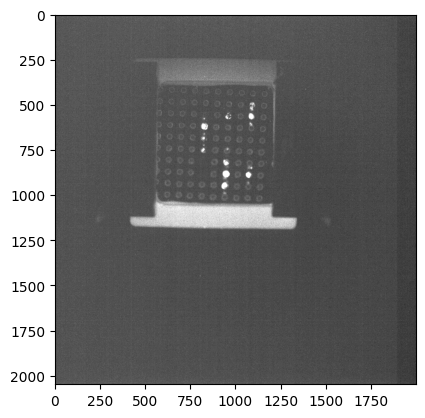

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

def open_fits_file(file_path):
    with fits.open(file_path, do_not_scale_image_data=True) as hdul:
        primary_hdu = hdul[0]
        image_data = primary_hdu.data

        bscale = primary_hdu.header.get('BSCALE', 1.0)
        bzero = primary_hdu.header.get('BZERO', 0.0)
        image_data = bscale * image_data + bzero
    return image_data

def scale_and_save(data, file_path, show=False):
    masked_image_data = np.ma.masked_invalid(data)
    mean_val = np.mean(masked_image_data)
    std_val = np.std(masked_image_data)
    vmin = mean_val - std_val
    vmax = mean_val + 2 * std_val

    scaled_data = np.clip(data, vmin, vmax)
    scaled_data = (scaled_data - vmin) / (vmax - vmin) 

    hdu = fits.PrimaryHDU(scaled_data)
    hdul = fits.HDUList([hdu])
    # hdul.writeto(f'{file_path[:-5]}_scaled.fits', overwrite=True)
    hdul.writeto(f'../images/experiment 9/output/with_signal_modified_{file_path[-6]}', overwrite=True)

    if show:
        plt.imshow(scaled_data, cmap='gray')
        plt.show()

file_path = '../images/experiment 9/100ms_without_BlackCover/with_signal_2.fits'
image = open_fits_file(file_path)
plt.imshow(image, cmap='gray')
scale_and_save(open_fits_file(file_path), file_path, show=True)


# get the different bead shapes and intensities from ds9
# save them as "neighbours"
# perform convolution with a threshold and loss function. if the loss function is less than the threshold then the current coordinates is a bead so measure intensity
# have a weighted matrix for the loss function, so it is very punishing if it doesn't have a "full circle" shape 

[5.47419396 5.         4.88953637]
 id xcentroid ycentroid sharpness roundness1 ... npix sky   peak flux  mag 
--- --------- --------- --------- ---------- ... ---- ---- ----- ---- -----
  1   1358.99      2.09      0.59       0.38 ...   25 0.00 28.00 1.05 -0.06
  2   1438.64     10.50      0.52       0.82 ...   25 0.00 24.00 1.20 -0.20
  3   1932.12     11.77      0.91       0.98 ...   25 0.00 31.00 1.09 -0.10
  4   1639.45     15.16      0.80       0.39 ...   25 0.00 28.00 1.03 -0.03
  5   1021.11     19.44      0.63       0.16 ...   25 0.00 28.00 1.23 -0.23
  6   1052.13     24.33      0.62       0.04 ...   25 0.00 24.00 1.00 -0.00
  7   1150.55     30.70      0.92       0.10 ...   25 0.00 34.00 1.03 -0.03
  8   1313.86    109.98      0.94       0.68 ...   25 0.00 36.00 1.06 -0.06
  9   1676.23    126.41      0.55      -0.77 ...   25 0.00 19.00 1.07 -0.07
 10    720.04    138.28      0.70      -0.10 ...   25 0.00 27.00 1.06 -0.07
...       ...       ...       ...        ... ...  ...

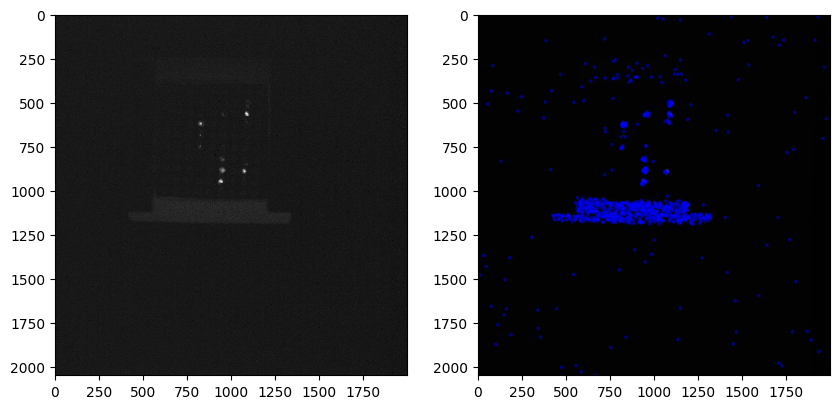

In [2]:
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.stats import sigma_clipped_stats, mad_std
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

file_path = '../images/experiment 9/100ms_without_BlackCover/with_signal_2.fits'
image = open_fits_file(file_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.imshow(image, cmap='grey')

mean, median, std = sigma_clipped_stats(image, sigma=3.0)  
print(np.array((mean, median, std)))  

daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(image - median) 
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'

sources.pprint(max_width=76)  

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())

ax1.imshow(image, cmap='grey', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5);



In [3]:
from photutils.segmentation import detect_sources, SourceCatalog
file_path = '../images/experiment 9/100ms_without_BlackCover/with_signal_2.fits'
image = open_fits_file(file_path)

mean, median, std = sigma_clipped_stats(image, sigma=3.0)
print(np.array((mean, median, std)))

threshold = 5. * std
segm = detect_sources(image - median, threshold, npixels=5)

props = SourceCatalog(image, segm)
table = props.to_table()

for col in table.colnames:
    if col not in ('id', 'npix'):
        table[col].info.format = '%.2f'
table.pprint(max_width=76)

positions = np.transpose((table['xcentroid'], table['ycentroid']))
apertures = CircularAperture(positions, r=4.0)

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image, cmap='Greys', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

[5.47419396 5.         4.88953637]


ValueError: Invalid format for column 'sky_centroid': could not display values in this column using this format